NB : les données peuvent être également téléchargées directement si besoin, pour être utilisées hors du SSP CLoud.
Exemple pour le fichier ci-dessus (même format de lien pour les autres challenges) : 

http://minio.lab.sspcloud.fr/gvimont/diffusion/hackathon-minarm-2024/AIVSAI/HC3.zip

In [10]:
local_path  = 'car_data/car_data'
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
# importing pytorch libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
# importing image required libraries
import time
import os
import PIL.Image as Image
from IPython.display import display
from torchvision.models import resnet18, ResNet18_Weights

# importing sklearn libraries for evaluation
from sklearn.metrics import confusion_matrix, classification_report
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [5]:
car_count_dict = {}
for folder_name in os.listdir(os.path.join(local_path, 'train')):
    count = len(os.listdir(os.path.join(local_path, 'train', folder_name)))
    car_count_dict[folder_name] = count

for folder_name in os.listdir(os.path.join(local_path, 'test')):
    count = len(os.listdir(os.path.join(local_path, 'test', folder_name)))
    car_count_dict[folder_name] += count

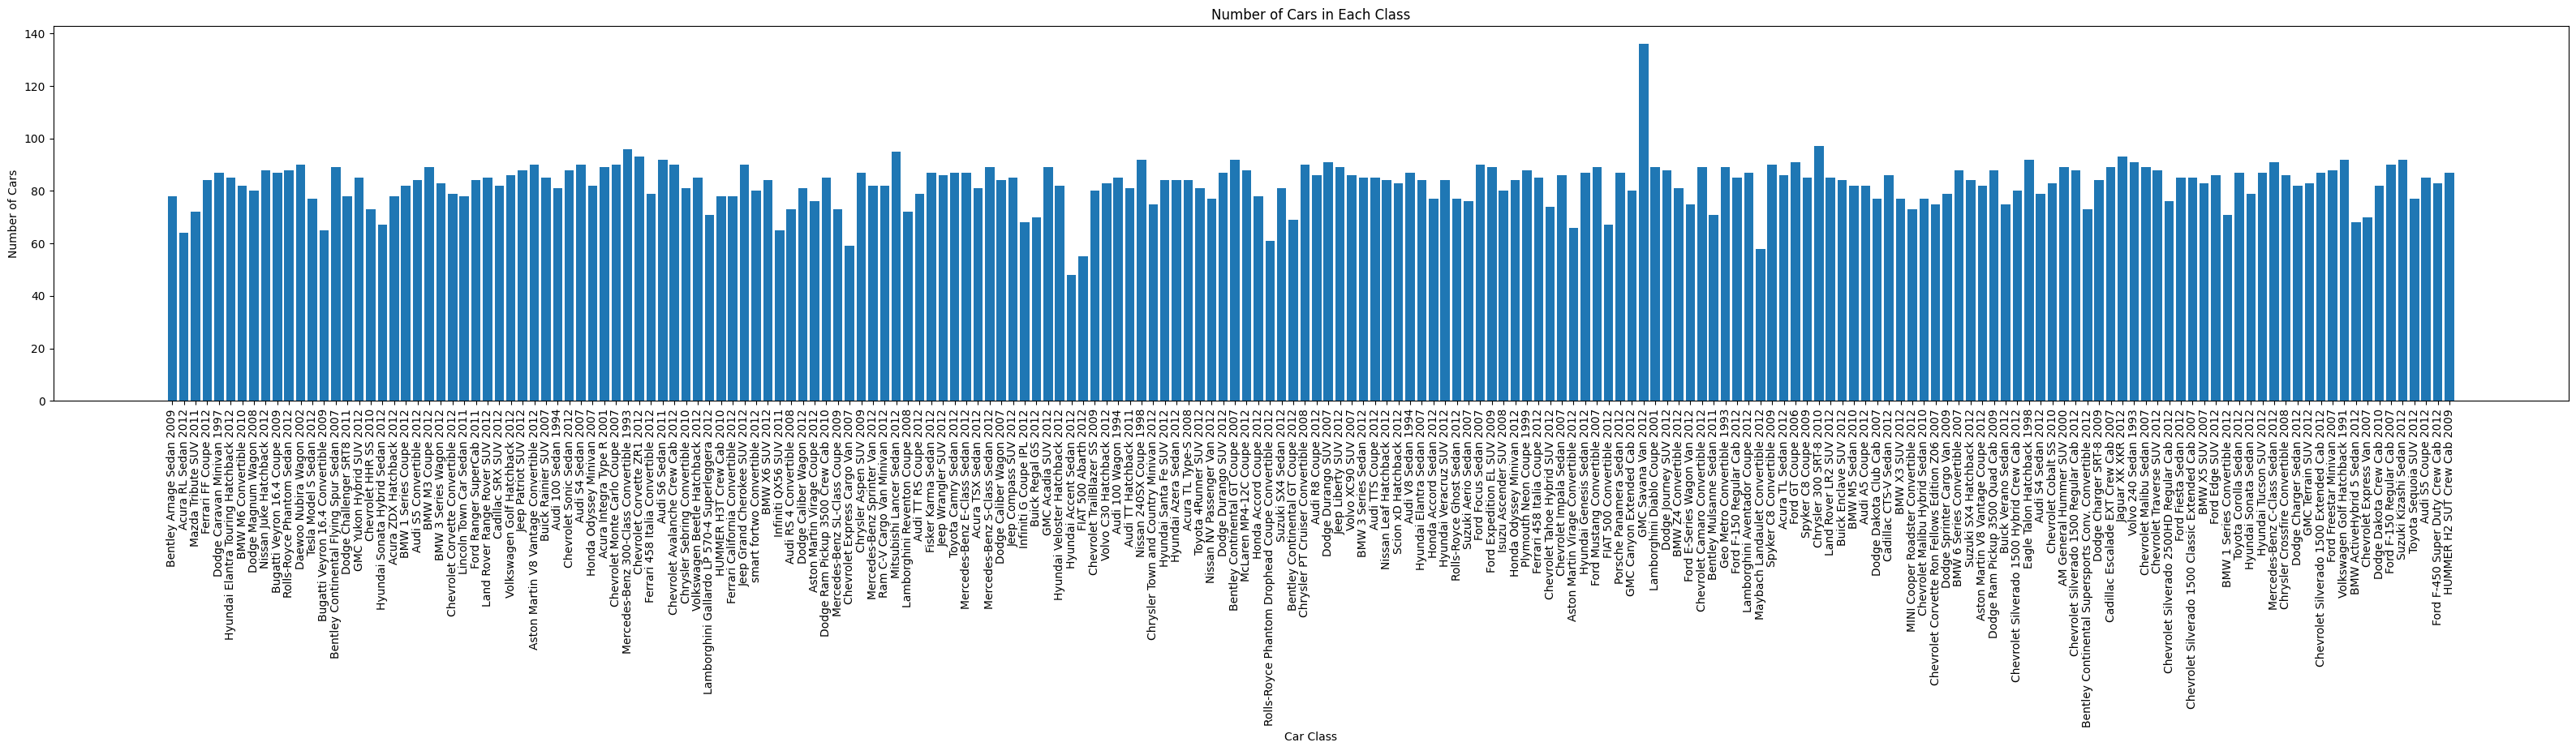

<Figure size 640x480 with 0 Axes>

In [6]:
plt.figure(figsize=(40, 6))
    # Create a bar chart
plt.bar(car_count_dict.keys(), car_count_dict.values())

# Add labels and title
plt.xlabel('Car Class')
plt.ylabel('Number of Cars')
plt.title('Number of Cars in Each Class')

# Rotate x-axis labels for better visibility
plt.xticks(rotation=90)

# Display the histogram
plt.show()
plt.savefig('image.png')

In [36]:
dataset_dir = local_path
# defining the transformation for the dataset
train_tfms = transforms.Compose([transforms.Resize((400, 400)),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(15),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
test_tfms = transforms.Compose([transforms.Resize((400, 400)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
test_time_tfms = transforms.Compose([transforms.Resize((400, 400)),
                                transforms.ToTensor(),
                                transforms.RandomRotation(90),
                                transforms.RandomHorizontalFlip(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# defining the dataset from the image folder 
# Here we use the folder names themselves as the class names
train_dataset = torchvision.datasets.ImageFolder(root=os.path.join(dataset_dir, 'train'), transform = train_tfms)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 32, shuffle=True, num_workers = 2)

test_dataset = torchvision.datasets.ImageFolder(root=os.path.join(dataset_dir, 'test'), transform = test_tfms)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 32, shuffle=False, num_workers = 2)

In [37]:
model = resnet18(weights=ResNet18_Weights.DEFAULT)
num_ftrs = model.fc.in_features
# getting the number of classes in the dataset
no_classes = len(train_dataset.classes)
# showing the architecture of the model
model.parameters

<bound method Module.parameters of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


In [38]:
# replace the last fc layer with an untrained one based on the number of classes we have in our dataset (requires grad by default)
model.fc = nn.Linear(num_ftrs, no_classes)
model = model.to(device)

# defining the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

"""
Here we will use learning rate schedular to change the learning rate while training our model. We are tracking the training accuracy
and measuring whether it increases by atleast 0.9 per epoch and if it hasn't increased by 0.9 reduce the learning by 0.1x.
However in this model it did not benefit me.
"""
lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)

In [39]:
def train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, device, n_epochs = 5):
    # keeping track of losses and the accuracies
    losses = []
    accuracies = []
    test_accuracies = []
    # set the model to train mode initially (This is important as some models behave differently in train and test time.)
    model.train()
    # loop over the epochs
    for epoch in tqdm(range(n_epochs)):
        # keep track of the time for training the model for each epoch
        since = time.time()
        running_loss = 0.0
        running_correct = 0.0
        # iterate over the training data
        for i, data in enumerate(train_loader, 0):
            # get the inputs and assign them to cuda
            inputs, labels = data
            # Transfer to GPU
            inputs = inputs.to(device)
            labels = labels.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward pass
            outputs = model(inputs)
            # get the predictions
            _, predicted = torch.max(outputs.data, 1)
            # calculate the loss
            loss = criterion(outputs, labels)
            # backward pass
            loss.backward()
            # optimize the weights
            optimizer.step()
            # calculate the loss
            running_loss += loss.item()
            # calculate the accuracy
            running_correct += (labels==predicted).sum().item()
        # calculate the duration for each epoch
        epoch_duration = time.time()-since
        epoch_loss = running_loss/len(train_loader)
        epoch_acc = 100/32*running_correct/len(train_loader)
        print("Epoch %s, duration: %d s, loss: %.4f, acc: %.4f" % (epoch+1, epoch_duration, epoch_loss, epoch_acc))
        # append the losses and the accuracies
        losses.append(epoch_loss)
        accuracies.append(epoch_acc)
        # switch the model to eval mode to evaluate on test data
        model.eval()
        test_acc = eval_model(model, test_loader, device)
        test_accuracies.append(test_acc)
        # re-set the model to train mode after validating
        model.train()
        scheduler.step(test_acc)
        since = time.time()
    print('Finished Training')
    return model, losses, accuracies, test_accuracies

In [40]:
def eval_model(model, test_loader, device, test_time_tsfm=None, num_augmentations=1):
    correct = 0.0
    total = 0.0
    with torch.no_grad():
        # Iterate over the test data and generate predictions.
        for i, data in enumerate(test_loader, 0):
            # Get inputs
            images, labels = data
            # Transfer to GPU
            images = images.to(device)
            labels = labels.to(device)
            # If test time augmentation is provided, apply transformations
            if test_time_tsfm is not None:
                augmented_images = []
                for img in images:
                    augmented_images.extend(img)
                    # Apply the transformation num_augmentations times
                    augmented_imgs = [test_time_tsfm(img) for _ in range(num_augmentations)]
                    # Stack the augmented images into a single tensor and add to the list
                    augmented_images.extend(augmented_imgs)
                # Convert the list of augmented images to a single tensor
                images = torch.stack(augmented_images)

            # Forward pass
            outputs = model(images)
            # Get predictions from the maximum value 
            _, predicted = torch.max(outputs.data, 1)
            # Total number of labels in the test data set
            total += labels.size(0) * num_augmentations
            # Total correct predictions
            correct += (predicted == labels.repeat(num_augmentations)).sum().item()
    # Calculate the accuracy
    test_acc = 100.0 * correct / total
    print('Accuracy of the network on the test images: %d %%' % (
        test_acc))
    return test_acc

In [41]:
n_epochs = 1
# train the model
model, training_losses, training_accs, test_accs = train_model(model, train_loader, 
                            test_loader, criterion, optimizer, lrscheduler, device, n_epochs=n_epochs)
# Save the model
torch.save(model.state_dict(), 'model.pth')

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1, duration: 86 s, loss: 4.2740, acc: 12.6471


100%|██████████| 1/1 [02:19<00:00, 139.27s/it]

Accuracy of the network on the test images: 34 %
Finished Training
